In [1]:
from numpy import int64
import numpy as np
import pandas as pd
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install Keras

In [4]:
#pip install tensorflow

In [5]:
No_history_days= 28
No_prediction_days=7
Test_year=2023
Test_month=3
Test_day=6

In [6]:
df = read_csv("VolumeHistory_2022_12_2023_02.csv",encoding='cp1252',parse_dates=True,dtype={"id_physician":str})
# df.dtypes
df.dropna(how='all',inplace=True)

In [7]:
phy_info=df[["id_physician","physician_company", "physician_classification"]].drop_duplicates()


In [8]:
# Group the data frame by AppointmentType and extract a number of stats from each group
df=df.groupby(
   ['id_physician','EncounterDate']
).agg(
    
         Encounters=('Encounters','sum'),    # get the sum Encounter per group
         Medialength=('medialen','sum') ,  # get the sum Medialength per group
         Appointments=('Actuals', "sum") # get the sum of Appointments per group
    
).reset_index()

In [9]:
df2=df.merge(phy_info, on ="id_physician") 
df2.shape

(103826, 7)

In [10]:
df2.drop(columns = "physician_company", inplace = True)

In [11]:
df2.drop_duplicates(keep="first",inplace=True)
df2.shape

(100719, 6)

In [12]:
phy_sample=df2["id_physician"].drop_duplicates().sample(n=500)

In [13]:
df2=df2.merge(phy_sample,on = "id_physician",validate="m:1")

In [14]:
# print(len(df2[pd.isnull(df2).any(axis=1)]))

In [15]:
print(len(df2[df2.isna().any(axis=1)]))

420


In [16]:
df2.dropna(how='all',inplace=True)

In [17]:
df2.shape

(12361, 6)

C:\Users\sindhumati.panigrahi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Encounters', ylabel='Density'>

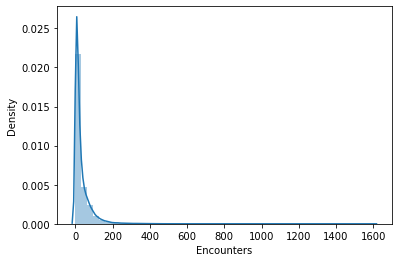

In [18]:
sns.distplot(df['Encounters'])

C:\Users\sindhumati.panigrahi\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Encounters', ylabel='Density'>

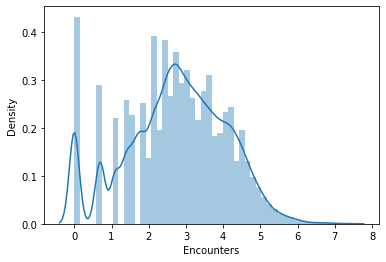

In [19]:
sns.distplot(np.log(df['Encounters']))

<AxesSubplot:>

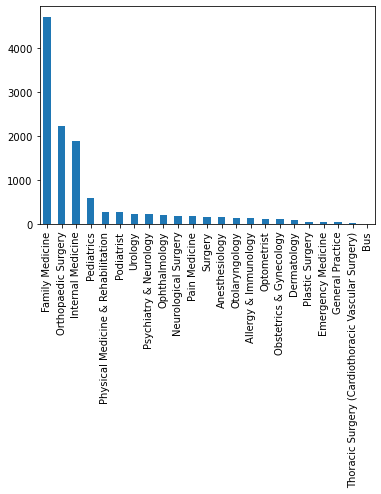

In [20]:
df2['physician_classification'].value_counts().plot(kind='bar')

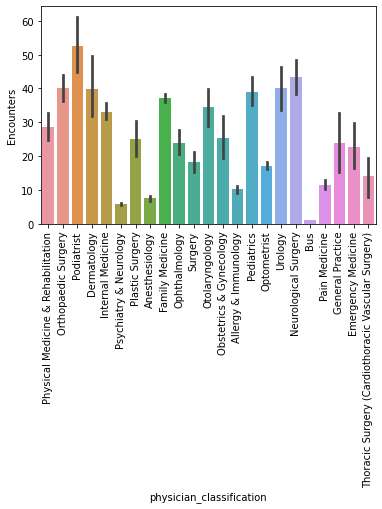

In [21]:
from matplotlib import pyplot as plt
sns.barplot(x=df2['physician_classification'],y=df2['Encounters'])
plt.xticks(rotation='vertical')
plt.show()

In [22]:
df2.corr()

C:\Users\sindhumati.panigrahi\AppData\Local\Temp\ipykernel_18320\1778878097.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr()


,Encounters,Medialength,Appointments
Encounters,1.000000,0.515977,0.460124
Medialength,0.515977,1.000000,0.241680
Appointments,0.460124,0.241680,1.000000


In [23]:
df2.describe()

,Encounters,Medialength,Appointments
count,12361.000000,1.236100e+04,12361.000000
mean,33.890705,2.429061e+07,10.169727
std,55.573655,5.437229e+07,9.798784
min,1.000000,1.000000e+03,0.000000
25%,7.000000,3.693000e+06,0.000000
50%,17.000000,1.054800e+07,10.000000
75%,40.000000,2.690000e+07,16.000000
max,1406.000000,3.262000e+09,66.000000


In [24]:
df2.isna().sum()

id_physician                  0
EncounterDate                 0
Encounters                    0
Medialength                   0
Appointments                  0
physician_classification    420
dtype: int64

In [25]:
df2.dtypes

id_physician                 object
EncounterDate                object
Encounters                  float64
Medialength                 float64
Appointments                float64
physician_classification     object
dtype: object

## Convert Object into int datatype

## Working with Date Features

In [26]:
# Converting to datetime datatype
df2['EncounterDate'] = pd.to_datetime(df2['EncounterDate'])

In [27]:
df2['EncounterDate_year'] = df2['EncounterDate'].dt.year 
df2["EncounterDate_Month_Number"] = df2["EncounterDate"].dt.month
# df2['EncounterDate_day'] = df2["EncounterDate"].dt.day
df2["EncounterDate_Week_Day"] = df2["EncounterDate"].dt.dayofweek
df2['EncounterDate_dayofyear'] = df2["EncounterDate"].dt.dayofyear
df2['EncounterDate_weekend'] = df2['EncounterDate'].dt.dayofweek >=5
df2['EncounterDate_week']=df2['EncounterDate'].dt.weekday
#df2=df2.drop(['EncounterDate'], axis=1)

#Monday is 0 and sunday is 6

In [28]:
import numpy as np

df2["EncounterDate_weekend"]= np.asarray(df2["EncounterDate_weekend"]).astype(np.float32)

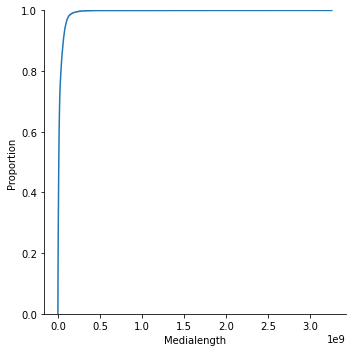

In [29]:
sns.displot(df2['Medialength'], kind= 'ecdf')

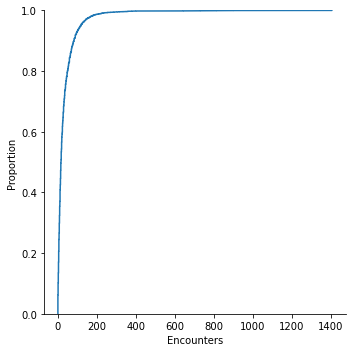

In [30]:
sns.displot(df2['Encounters'], kind= 'ecdf')

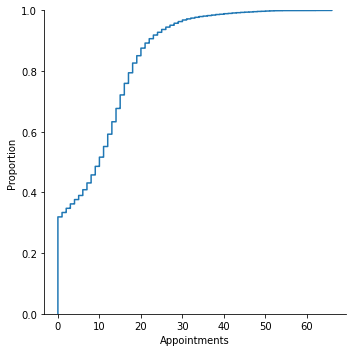

In [31]:
sns.displot(df2['Appointments'], kind= 'ecdf')

(0.0, 20.0)

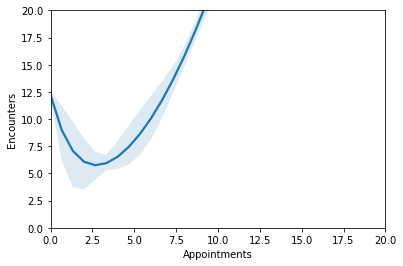

In [32]:
ax=sns.regplot(data=df2,x='Appointments', y='Encounters',order=10,scatter=False)
ax.set_xlim(0,20)
ax.set_ylim(0,20)

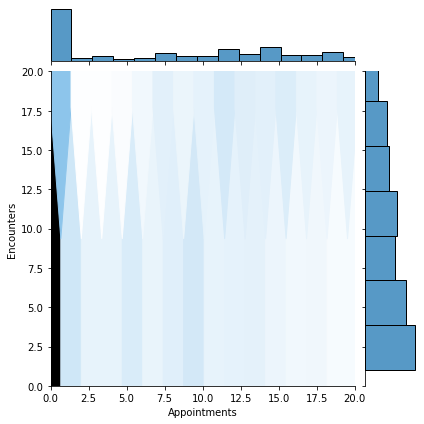

In [33]:
bx=sns.jointplot(data=df2,x='Appointments', y='Encounters',kind='hex',xlim=(0,20),ylim=(0,20))

In [34]:
def unique_col_values(df2):
    for column in df2:
        if df2[column].dtypes=='object':
            print(f'{column}: {df2[column].unique()}')
# To check the unique values in dataset           
# df2.apply(lambda x:len(x.unique()))

In [35]:
unique_col_values(df2)

id_physician: ['11311' '24271' '26801' '27001' '27371' '28591' '29891' '29901' '30861'
 '31181' '31991' '32141' '33201' '35421' '38151' '38531' '41581' '41761'
 '42601' '44681' '44781' '44941' '46261' '47261' '47491' '48461' '49661'
 '50681' '50801' '51031' '52384' '52545' '52621' '52633' '52634' '52799'
 '52814' '52824' '52907' '53286' '53408' '53556' '53758' '53844' '53882'
 '53889' '53893' '53988' '5401' '54013' '54031' '54138' '54209' '54227'
 '54240' '54361' '54384' '54480' '54524' '54687' '54696' '54769' '54779'
 '54781' '54910' '54911' '54973' '55073' '55111' '55114' '55209' '55285'
 '55444' '55631' '55873' '56030' '56058' '56074' '56198' '56365' '56366'
 '56398' '56507' '56533' '56580' '56655' '56790' '56850' '56903' '57054'
 '57137' '57311' '57344' '57452' '57538' '57633' '57855' '57990' '58099'
 '58269' '58270' '58279' '58285' '58304' '58319' '58336' '58356' '58395'
 '58421' '58458' '58495' '58504' '58541' '58543' '58554' '58559' '58564'
 '58788' '58789' '58790' '58821' '5882

C:\Users\sindhumati.panigrahi\AppData\Local\Temp\ipykernel_18320\2722710520.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2_corr=df2.corr().round(2)
C:\Users\sindhumati.panigrahi\AppData\Local\Temp\ipykernel_18320\2722710520.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plot=sns.heatmap(df2.corr().round(2))


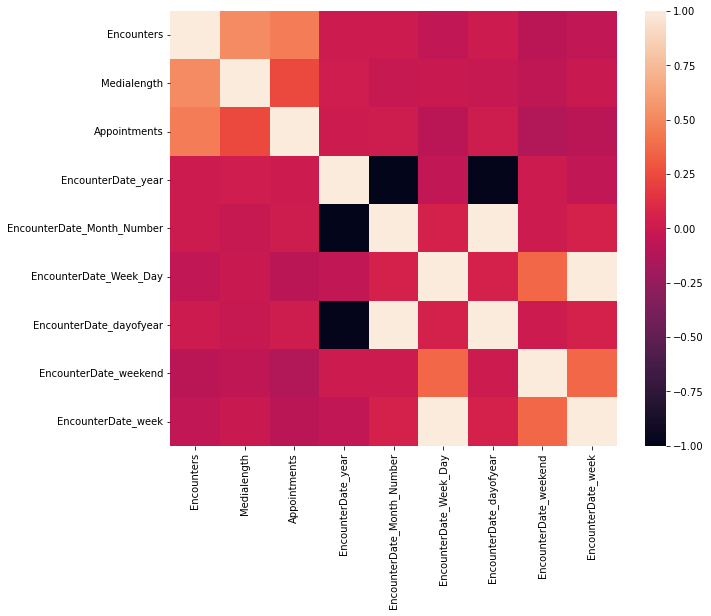

In [36]:
import matplotlib.pyplot as plt
df2_corr=df2.corr().round(2)
plt.figure(figsize=(10,8))
plot=sns.heatmap(df2.corr().round(2))

In [37]:
df2.corr()['Encounters']

C:\Users\sindhumati.panigrahi\AppData\Local\Temp\ipykernel_18320\4199510796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df2.corr()['Encounters']


Encounters                    1.000000
Medialength                   0.515977
Appointments                  0.460124
EncounterDate_year            0.002629
EncounterDate_Month_Number   -0.002403
EncounterDate_Week_Day       -0.053355
EncounterDate_dayofyear      -0.002766
EncounterDate_weekend        -0.079618
EncounterDate_week           -0.053355
Name: Encounters, dtype: float64

In [38]:
# df2=pd.get_dummies(data=df2, columns= ['physician_company','physician_classification'])

In [39]:
# scale_columns= ['Appointments','Encounters','Medialength']
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# df2[scale_columns]= scaler.fit_transform(df2[scale_columns])
# print(df2)

In [40]:
df2.query('Appointments>0').shape
#df2.shape

(8413, 12)

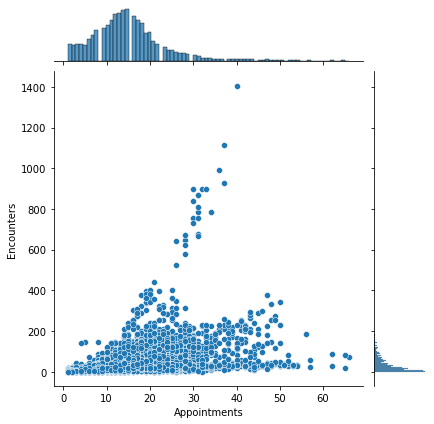

In [41]:
plot=sns.jointplot(data=df2.query('Appointments>0'),x="Appointments",y="Encounters")

In [42]:
df2["Medialength"]=df2["Medialength"].astype(int)
df2["Appointments"]=(df2["Appointments"]).astype(int)
df2['Medialength'].describe()

count    1.236100e+04
mean     2.385298e+07
std      4.989626e+07
min     -2.147484e+09
25%      3.693000e+06
50%      1.053600e+07
75%      2.687600e+07
max      1.957000e+09
Name: Medialength, dtype: float64

In [43]:
import datetime
train=df2[pd.to_datetime(df2["EncounterDate"]).dt.date<datetime.date(2023,2,11)]
test=df2[pd.to_datetime(df2["EncounterDate"]).dt.date>=datetime.date(2023,2,11)]
#9 weeks for training
#3 weeks for testing 
train.shape, test.shape

((9680, 12), (2681, 12))

In [44]:
# def Stacked_History(Hist,Schedule,Day):
#     # Extraction of last 28days data and scheduled infromation for next 7 days 
#     #and stack encounter in one DataFrame
#     #Extraction of last 28 days actual
    
#     Day_M28=Day-datetime.timedelta(days=28)
#     Extracted_History=Hist[["id_physician","Encounters","Medialength","Appointments",
#                 "EncounterDate"]].query("(EncounterDate>@Day_M28) and (EncounterDate<@Day)").copy()
#     Extracted_History['Days_previous']= np.datetime64(Day)-Extracted_History["EncounterDate"]
#     Rowlist=[]
    
#     #Extraction of last 28 days(history) +7 days(Future) Schedules 
#     Day_plus7=Day+datetime.timedelta(days=7)
#     Extracted_Schedule=Schedule.query("(EncounterDate>@Day_M28) and (EncounterDate<@Day_plus7)").copy()
#     Extracted_Schedule['Days_previous']= np.datetime64(Day)-Extracted_Schedule["EncounterDate"]
#     #Stack the encounters in one DataFrame
#     for id_physician_ in Extracted_History["id_physician"].drop_duplicates(): 
#         By_physician_hist=Extracted_History.query("id_physician==@id_physician_")
#         By_physician_hist=By_physician_hist.drop_duplicates()
#         if sum(By_physician_hist.duplicated(subset="Days_previous"))!=0:
#             print("By_physician_hist", By_physician_hist)
#         assert sum(By_physician_hist.duplicated(subset="Days_previous"))==0
#     # Created by Physician Schedule
#         By_physician_sche=Extracted_Schedule.query("id_physician==@id_physician_")  
#         By_physician_sche=By_physician_sche.drop_duplicates()
#         assert sum(By_physician_sche.duplicated(subset="Days_previous"))==0
#     # Predict encounter for next 7 days
# #         Row=pd.wide_to_long(By_physician_hist,stubnames="w",j="Encounters",i="Days_previous",sep=".")
# #         print(By_physician_hist.columns)
# #         print(Row) 
# #         stop
#         Row_Hist=pd.pivot(By_physician_hist,columns="Days_previous",index="id_physician",
#                      values=['Encounters', 'Medialength'])
#     # Pivoting on Physician Schedule
#         Row_Sche=pd.pivot(By_physician_sche,columns="Days_previous",index="id_physician",
#                      values=['Appointments'])
#         Row=pd.concat([Row_Hist,Row_Sche],axis=1)
        
#         Rowlist.append(Row)
#     Out=pd.concat(Rowlist)
#     return Out

In [45]:
def Stacked_History_Prediction(Hist,Schedule,Day,No_history_days=No_history_days,No_prediction_days=No_prediction_days):
#Extraction of last 28days data and scheduled infromation for next 7 days 
#and stack encounter in one DataFrame
#Extraction of last 28 days actual
    Day_M28=Day-datetime.timedelta(days=No_history_days)
    
#     print("Hist_columns:", Hist.columns)
    Extracted_History=Hist[["id_physician","Encounters","Medialength","Appointments",
        "EncounterDate"]].query("(EncounterDate>@Day_M28) and (EncounterDate<@Day)").copy()
    
#     print("Extracted_History_columns:", Extracted_History.columns)
    Extracted_History['Days_previous']= (np.datetime64(Day)-Extracted_History["EncounterDate"]).dt.days
    Rowlist=[]
#     print("Extracted_History:",Extracted_History["Days_previous"])
#     print("Extracted_History 20 day previous :",Extracted_History.query("Days_previous==20").shape)
    Day_P7=Day+datetime.timedelta(days=No_prediction_days)
    Extracted_Prediction=Hist[["id_physician","Encounters","Medialength","Appointments",
        "EncounterDate"]].query("(EncounterDate<@Day_P7) and (EncounterDate>@Day)").copy()
    Extracted_Prediction['Days_previous']= (np.datetime64(Day)-Extracted_Prediction["EncounterDate"]).dt.days
    
    
    #Extraction of last 28 days(history) +7 days(Future) Schedules 
    Day_plus7=Day+datetime.timedelta(days=No_prediction_days)
    Extracted_Schedule=Schedule.query("(EncounterDate>@Day_M28) and (EncounterDate<@Day_plus7)")\
    [["Appointments","EncounterDate","id_physician"]].copy()
    
    Extracted_Schedule['Days_previous']= (np.datetime64(Day)-Extracted_Schedule["EncounterDate"]).dt.days
#     Stack the encounters in one DataFrame
#     print(Extracted_History["id_physician"].nunique())
    for id_physician_ in Extracted_History["id_physician"].drop_duplicates(): 
#         print("id_physician",id_physician_)
        By_physician_hist=Extracted_History.query("id_physician==@id_physician_")
        By_physician_hist=By_physician_hist.drop_duplicates() #keep=last
#         print("By_physician_hist_shape:",By_physician_hist.shape)
#         if sum(By_physician_hist.duplicated(subset="Days_previous"))!=0:          
        assert sum(By_physician_hist.duplicated(subset="Days_previous"))==0
    #Created by Physician Schedule
#         print("By_physician_hist_shape:",By_physician_hist.shape)
        By_physician_sche=Extracted_Schedule.query("id_physician==@id_physician_")  
        By_physician_sche=By_physician_sche.drop_duplicates(subset="Days_previous")
        assert sum(By_physician_sche.duplicated(subset="Days_previous"))==0
    #Predict encounter for next 7 days
        By_physician_pred= Extracted_Prediction.query("id_physician==@id_physician_")
        By_physician_pred=By_physician_pred.drop_duplicates()

#         print(By_physician_hist.query("Days_previous==20").shape)
#         print(By_physician_sche.query("Days_previous==20").shape)
        Row_Hist=pd.pivot(By_physician_hist,columns="Days_previous",index="id_physician",
                     values=['Encounters', 'Medialength','Appointments'])
#         print("Row_Hist_columns:", Row_Hist.columns)
        
    # Pivoting on Physician Schedule
        Row_Sche=pd.pivot(By_physician_sche,columns="Days_previous",index="id_physician",
                     values=['Appointments'])
#         print("Row_Sche_columns:", Row_Sche.columns)
        Row_Pred=pd.pivot(By_physician_pred,columns="Days_previous",index="id_physician",
                     values=['Encounters', 'Medialength'])
#         print("Row_Pred_columns:", Row_Pred.columns)
      
#         Row=pd.concat([Row_Hist,Row_Sche,Row_Pred],axis=1)
        Row1=Row_Hist.merge(Row_Sche, on="id_physician",validate='1:1',suffixes=
                        ["","_Sche"])
        Row=Row1.merge(Row_Pred, on="id_physician",validate='1:1', suffixes=
                        ["","_Pred"])
#         print("Row_columns:", Row.columns)
        
#         assert ("Appointments",20) in Row.columns
        Row[("EncounterDate","empty")]=Day 
        Row[("Current_Day","empty")]=Day 
        Rowlist.append(Row)
    Out=pd.concat(Rowlist)
    return Out

In [46]:
predicted_encounters=[("Encounters",day)
                     for day in range(-1,-(No_prediction_days),-1)]

In [47]:
predicted_medialength= [("Medialength",day)
                     for day in range(-1,-(No_prediction_days),-1)]

In [48]:
predicted_encounters, predicted_medialength

([('Encounters', -1),
  ('Encounters', -2),
  ('Encounters', -3),
  ('Encounters', -4),
  ('Encounters', -5),
  ('Encounters', -6)],
 [('Medialength', -1),
  ('Medialength', -2),
  ('Medialength', -3),
  ('Medialength', -4),
  ('Medialength', -5),
  ('Medialength', -6)])

In [49]:
Appointments_df=read_csv("PhysicianAppointments.csv",parse_dates=True)
Appointments_df=Appointments_df.merge(phy_sample,on="id_physician", validate="m:1")
Appointments_df.shape


(9183, 6)

In [50]:
Appointments_df[pd.isnull(Appointments_df).any(axis=1)]

,id_physician,PROVIDERUSERID,EncounterDate,SHIFT,Appointments,DATASOURCE


In [51]:
Appointments_df.dropna(how='all',inplace=True)

In [52]:
Appointments_df.shape

(9183, 6)

In [53]:
# Converting to datetime datatype
Appointments_df['EncounterDate'] = pd.to_datetime(Appointments_df['EncounterDate'])
Appointments_df.shape

(9183, 6)

In [54]:
print(train["id_physician"].nunique())

445


In [55]:
Schedule_df=Appointments_df[["id_physician","EncounterDate","Appointments"]]
Stacked_pred=Stacked_History_Prediction(Hist=train,Schedule=Schedule_df,
                    Day=(datetime.date(2023,2,11)),
                        No_history_days=No_history_days,No_prediction_days=No_prediction_days)
print("Stacked_pred",Stacked_pred.shape)
print("Stacked_pred",Stacked_pred.head(5))
# "id_physician" in Stacked_pred

Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Stacked_pred (0, 86)
Stacked_pred Empty DataFrame
Columns: [(Encounters, 1), (Encounters, 3), (Encounters, 4), (Encounters, 8), (Encounters, 9), (Encounters, 10), (Encounters, 15), (Encounters, 22), (Encounters, 23), (Encounters, 24), (Encounters, 25), (Medialength, 1), (Medialength, 3), (Medialength, 4), (Medialength, 8), (Medialength, 9), (Medialength, 10), (Medialength, 15), (Medialength, 22), (Medialength, 23), (Medialength, 24), (Medialength, 25), (Appointments, 1), (Appointments, 3), (Appointments, 4), (Appointments,

In [56]:
def stacked_history_pred_date(train,Year,Month,Start_date,End_date,
                No_history_days=No_history_days,No_prediction_days=No_prediction_days):
    Rowlist_Stacked_History=[]
    for day in range(Start_date,End_date):

        Stacked=Stacked_History_Prediction(Hist=train,Schedule=train[["id_physician","EncounterDate","Appointments"]],
                                           Day=(datetime.date(Year,Month,day)),
                        No_history_days=No_history_days,No_prediction_days=No_prediction_days)
        Stacked[("Current_Day","empty")]=day
        Rowlist_Stacked_History.append(Stacked)

    Output_stacked=pd.concat(Rowlist_Stacked_History).copy()
    return Output_stacked

In [57]:
Feb_stacked=stacked_history_pred_date(df2,2023,2,1,28,No_history_days,No_prediction_days)
Feb_stacked.shape
#28,8, save in New CSV

Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Hist_columns: Index(['id_physician', 'EncounterDate', 'E

Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Hist_columns: Index(['id_physician', 'EncounterDate', 'E

(8384, 129)

In [58]:
predicted_encounters_in_Feb_stacked=[column for column in predicted_encounters if column in Feb_stacked]


In [59]:
Feb_stacked[("EncounterDate","empty")]

id_physician
11311    2023-02-01
24271    2023-02-01
26801    2023-02-01
27001    2023-02-01
27371    2023-02-01
            ...    
77126    2023-02-27
77165    2023-02-27
77172    2023-02-27
8611     2023-02-27
9811     2023-02-27
Name: (EncounterDate, empty), Length: 8384, dtype: object

In [60]:
Feb_stacked_copy=Feb_stacked.copy()
Feb_stacked_copy.columns=['%s.%s'%(a[0], a[1]) for a in Feb_stacked_copy.columns]

In [61]:
Feb_stacked_copy.to_csv("Feb_data.tsv",sep="\t")

In [62]:
Feb_stacked=pd.read_csv("Feb_data.tsv",sep="\t",low_memory=False)
Feb_stacked.columns.sort_values(ascending=False)

Index(['id_physician', 'Medialength.9', 'Medialength.8', 'Medialength.7',
       'Medialength.6', 'Medialength.5', 'Medialength.4', 'Medialength.3',
       'Medialength.27', 'Medialength.26',
       ...
       'Appointments.18', 'Appointments.17', 'Appointments.16',
       'Appointments.15', 'Appointments.14', 'Appointments.13',
       'Appointments.12', 'Appointments.11', 'Appointments.10',
       'Appointments.1'],
      dtype='object', length=130)

In [63]:
Feb_stacked.dropna(subset="EncounterDate.empty",inplace=True)
Feb_stacked=Feb_stacked[Feb_stacked["EncounterDate.empty"]!="empty"]
Feb_stacked

,id_physician,Encounters.5,Encounters.12,Encounters.13,Encounters.14,Encounters.15,Encounters.19,Encounters.20,Encounters.21,Encounters.22,...,Medialength.17,Appointments.17,Appointments_Sche.17,Appointments_Sche.-4,Encounters.-4,Medialength.-4,Encounters.24,Medialength.24,Appointments.24,Appointments_Sche.24
0,11311,126.0,120.0,180.0,65.0,90.0,96.0,156.0,90.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24271,13.0,12.0,31.0,19.0,12.0,6.0,16.0,14.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26801,25.0,20.0,29.0,22.0,29.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27001,16.0,31.0,23.0,26.0,13.0,NaN,32.0,30.0,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27371,NaN,NaN,NaN,NaN,12.0,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,77126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8380,77165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8381,77172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6830000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8382,8611,14.0,19.0,20.0,NaN,NaN,20.0,18.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
predicted_encounters=['%s.%s'%("Encounters",day)
                     for day in range(-1,-(No_prediction_days),-1)]
predicted_medialength= ['%s.%s'%("Medialength",day)
                     for day in range(-1,-(No_prediction_days),-1)]
predicted_encounters_in_Feb_stacked=[column for column in predicted_encounters if column in Feb_stacked]


In [65]:
train_pred=Feb_stacked[pd.to_datetime(Feb_stacked["EncounterDate.empty"]).dt.date<datetime.date(2023,2,11)]
test_pred= Feb_stacked[pd.to_datetime(Feb_stacked["EncounterDate.empty"]).dt.date>datetime.date(2023,2,11)]
train_pred.shape,test_pred.shape

((3175, 130), (4886, 130))

In [66]:
Feb_stacked["EncounterDate.empty"].unique()

array(['2023-02-01', '2023-02-02', '2023-02-03', '2023-02-04',
       '2023-02-05', '2023-02-06', '2023-02-07', '2023-02-08',
       '2023-02-09', '2023-02-10', '2023-02-11', '2023-02-12',
       '2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
       '2023-02-17', '2023-02-18', '2023-02-19', '2023-02-20',
       '2023-02-21', '2023-02-22', '2023-02-23', '2023-02-24',
       '2023-02-25', '2023-02-26', '2023-02-27'], dtype=object)

In [67]:
X_train_pred =train_pred.drop(columns= predicted_encounters + predicted_medialength,errors="ignore")
X_train_pred= X_train_pred.drop(['EncounterDate.empty'], axis=1)
Y_train_pred_7=train_pred[predicted_encounters_in_Feb_stacked]
X_test_pred=test_pred.drop(columns=predicted_encounters + predicted_medialength,errors="ignore")
X_test_pred= X_test_pred.drop(['EncounterDate.empty'], axis=1)
Y_test_pred_7=test_pred[predicted_encounters_in_Feb_stacked]

X_test_pred.columns

Index(['id_physician', 'Encounters.5', 'Encounters.12', 'Encounters.13',
       'Encounters.14', 'Encounters.15', 'Encounters.19', 'Encounters.20',
       'Encounters.21', 'Encounters.22',
       ...
       'Appointments_Sche.10', 'Encounters.17', 'Medialength.17',
       'Appointments.17', 'Appointments_Sche.17', 'Appointments_Sche.-4',
       'Encounters.24', 'Medialength.24', 'Appointments.24',
       'Appointments_Sche.24'],
      dtype='object', length=117)

In [274]:
# def random_forest_day(X_train_pred,Y_train_pred_7,X_test_pred,Y_test_pred_7,day):

#     Enc_day="Encounters.%d"%day
#     New_train_columns=X_train_pred.columns
#     New_train_columns.sort_values()
#     LX_train_pred=X_train_pred[New_train_columns].copy()
#     LX_train_pred.fillna(value=0,inplace=True)

#     LX_test_pred=X_test_pred[New_train_columns].copy()
#     LX_test_pred.fillna(value=0,inplace=True)
# #     print(len(LX_test_pred.columns))

#     LY_train_pred=Y_train_pred_7[Enc_day].copy()

#     LY_train_pred.columns=[day]
#     LY_train_pred.fillna(value=0,inplace=True)
    
#     if Y_test_pred_7 is None:
#         pass
#     else:
#         LY_test_pred=Y_test_pred_7.copy()
#         LY_test_pred.fillna(value=0,inplace=True)

#     model = RandomForestRegressor(n_estimators=100,
#                                   criterion='squared_error',
#                                   random_state=None,
#                                   max_samples= None,
#                                   max_features= 0.8 ,
#                                   max_depth=60)

#     model.fit(LX_train_pred, LY_train_pred)
#     print(LX_test_pred)
#     y_pred_RF = model.predict(LX_test_pred)
    
#     y_pred_RF_df=pd.DataFrame({Enc_day+"_predicted":y_pred_RF},index=LX_test_pred.index)
#     if Y_test_pred_7 is None:
#         df_result=pd.concat([LX_test_pred,y_pred_RF_df],axis=1,join = 'outer')
#     else:
#         df_result=pd.concat([LX_test_pred,LY_test_pred,y_pred_RF_df],axis=1,join = 'outer')

#     return df_result

In [378]:
#Copy of Random forest
def add_random_forest_day(X_train_pred,Y_train_pred_7,
                          X_test_pred,Y_test_pred_7,day,input_Dataframe,predicted_column_name):

    Enc_day="Encounters.%d"%day
    New_train_columns=X_train_pred.columns
    New_train_columns.sort_values()
    LX_train_pred=X_train_pred[New_train_columns].copy()
    LX_train_pred.fillna(value=0,inplace=True)
    LX_train_pred.drop(columns = ['id_physician', 'Current_Day.empty'],inplace=True)
    print("LX_train_pred_describe:",LX_train_pred.describe())
    
    LX_test_pred=X_test_pred[New_train_columns].copy()
    LX_test_pred.fillna(value=0,inplace=True)
    LX_test_pred.drop(columns = ['id_physician', 'Current_Day.empty'],inplace=True)
    print("LX_test_pred_describe:",LX_test_pred.describe())

#     res=LX_test_pred.select_dtypes(include=[datetime.date])
#     print("Result:\n",res.columns)
#     print(len(LX_test_pred.columns))

    LY_train_pred=Y_train_pred_7[Enc_day].copy()

    LY_train_pred.columns=[day]
    LY_train_pred.fillna(value=0,inplace=True)
    print("LY_train_pred_describe:",LY_train_pred.describe())
    
    if Y_test_pred_7 is None:
        pass
    else:
        LY_test_pred=Y_test_pred_7.copy()
        LY_test_pred.fillna(value=0,inplace=True)

    model = RandomForestRegressor(n_estimators=100,
                                  criterion='squared_error',
                                  random_state=None,
                                  max_samples= None,
                                  max_features= 0.8 ,
                                  max_depth=60)

    model.fit(LX_train_pred, LY_train_pred)
#     print(LX_test_pred)
    y_pred_RF = model.predict(LX_test_pred)
    physician_id_y_pred_RF=pd.DataFrame({"id_physician":X_test_pred["id_physician"].astype(str),
                                         predicted_column_name : y_pred_RF})
    print("physician_id_y_pred_RF_columns:", physician_id_y_pred_RF.columns)
    print("physician_id_y_pred_RF_DTYPES:", physician_id_y_pred_RF.dtypes)
    result_df=input_Dataframe.merge(physician_id_y_pred_RF,on="id_physician",validate="1:1")
    print("result_df_columns:", result_df.columns)
#     y_pred_RF_df=pd.DataFrame({Enc_day+"_predicted":y_pred_RF},index=LX_test_pred.index)
    return result_df

In [379]:
X_test_pred.dtypes

id_physician              int64
Encounters.5            float64
Encounters.12           float64
Encounters.13           float64
Encounters.14           float64
                         ...   
Appointments_Sche.-4    float64
Encounters.24           float64
Medialength.24          float64
Appointments.24         float64
Appointments_Sche.24    float64
Length: 117, dtype: object

In [380]:
print(len(X_test_pred["id_physician"].duplicated()))

4886


In [381]:
X_test_pred.query("id_physician =='15581'")

,id_physician,Encounters.5,Encounters.12,Encounters.13,Encounters.14,Encounters.15,Encounters.19,Encounters.20,Encounters.21,Encounters.22,...,Appointments_Sche.10,Encounters.17,Medialength.17,Appointments.17,Appointments_Sche.17,Appointments_Sche.-4,Encounters.24,Medialength.24,Appointments.24,Appointments_Sche.24


In [382]:
print(len(Appointments_df.query("id_physician =='15581'")))

0


In [383]:
print(len(df2.query("id_physician =='15581'")))

0


In [384]:
D=X_test_pred[X_test_pred["id_physician"].duplicated()].sort_values("id_physician")
print(len(D))

4512


In [385]:
T=X_test_pred["id_physician"].value_counts()
print(T)

66998    16
66239    16
61965    16
62385    16
62479    16
         ..
73642     2
74950     1
54209     1
69604     1
70970     1
Name: id_physician, Length: 374, dtype: int64


In [386]:
Only_physician_id=df2[["id_physician"]].drop_duplicates(keep="first")
# Only_physician_id.head(20)

In [387]:
predicted_date=(datetime.date(Test_year,Test_month,(Test_day))).strftime("%Y-%m-%d")
 #need to work on test days later
predicted_date


'2023-03-06'

In [388]:
# add_random_forest_day(X_train_pred,Y_train_pred_7,
#                           X_test_pred,Y_test_pred_7,day=(-1),
#                       input_Dataframe=Only_physician_id,predicted_column_name=predicted_date)

In [389]:
# Result_day1=add_random_forest_day(X_train_pred,Y_train_pred_7,X_test_pred,Y_test_pred_7,day=-1)

In [390]:
df2.columns

Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week'],
      dtype='object')

In [391]:
def Test_input(Hist,Appointments_by_shift,Current_Year, Current_Month,Current_Date):
    
#     Hist_Physician=set(hist["id_physician"])
#     App_Physician=set(Appointments_by_shift["id_physician"])
#     All_Physician=Hist_Physician.union(App_Physician)
    Appointments=Appointments_by_shift.groupby(["id_physician","EncounterDate"])\
                        .agg(Appointments=("Appointments","sum")).reset_index()
    
#     print("Appointments_NaN:",Appointments[Appointments.isna().any(axis=1)])
    assert Appointments[Appointments.isna().any(axis=1)].shape[0]==0
    Day=(datetime.date(Current_Year, Current_Month,Current_Date))
    Day_dt64=np.datetime64(Day)

    #1. add appointmnents to the Raw history
#     Raw_hist_plus_appointment=pd.concat([Hist,Appointments], axis=0,join ='outer') 
    Raw_hist_plus_appointment=Hist.merge(Appointments, on =["id_physician","EncounterDate"],
                how ='outer',suffixes=['', '_Appointments'],indicator=True,validate="1:1")
    Appointment_conflicts=(Raw_hist_plus_appointment["Appointments"]!=
                Raw_hist_plus_appointment["Appointments_Appointments"])
#     print(Appointment_conflicts)
#     assert sum(Appointment_conflicts)==0
#     print("Raw_hist_plus_appointment_columns:",Raw_hist_plus_appointment.columns)
#     assert "Appointments" in Raw_hist_plus_appointment.columns
#     T=Raw_hist_plus_appointment[Raw_hist_plus_appointment.isna().any(axis=1)]
#     print(T.head(10))
#     print("Raw_hist_plus_appointment_NaN:",len(T))
#     print("Raw_hist_plus_appointment_NaN:",Raw_hist_plus_appointment[Raw_hist_plus_appointment.isna().any(axis=1)])


    Raw_hist_plus_appointment.drop_duplicates(subset=["id_physician","EncounterDate"],keep="first",inplace=True)

    #2. Run the stacked (Raw history+Appointment)
#     assert "Appointments" in Raw_hist_plus_appointment.columns
    Stacked_History=Stacked_History_Prediction(Raw_hist_plus_appointment,Appointments,Day,\
                        No_history_days=No_history_days,No_prediction_days=No_prediction_days)
    print("Stacked_History_describe:",Stacked_History.describe())
#     print("Stacked_History_NaN:",Stacked_History[Stacked_History.isna().any(axis=1)])
    print("Stacked_History_columns:",Stacked_History.columns)
    
#     print(Stacked_History[["EncounterDate"]].dtypes)
    assert ("EncounterDate","empty") in Stacked_History.columns
    assert "EncounterDate" in Stacked_History.columns
#     assert ("Appointments",20) in Stacked_History.columns
#     Test=Stacked_History[Stacked_History["Current_Day.empty"]==Day_dt64]
    K=Stacked_History.drop_duplicates(subset=[("EncounterDate","empty")])
#     print("Stacked_History_encounter_dates:",Stacked_History.drop_duplicates(subset=["EncounterDate"]))
    print("Stacked_History_encounter_dates:",K)
    Test=Stacked_History[Stacked_History[("EncounterDate","empty")]==Day_dt64]
    print("DAY:",Day_dt64)
    print("Test_NaN:",Test[Test.isna().any(axis=1)])
    Test.columns=['%s.%s'%(a[0], a[1]) for a in Test.columns]
    print("Test_describe:",Test.describe())
#     assert "Appointments.20" in Test.columns
#     print(Test)
#    Test=Stacked_History.query("EncounterDate==@Day_dt64")
    return Test

In [392]:
 #3.Extract test data for current day
TI1=Test_input(df2,Appointments_df,Test_year,Test_month,Test_day)
# # print(len(TI1["id_physician"]))
# print(TI1.shape)
TI1['EncounterDate.empty'] = TI1['EncounterDate.empty'].apply(pd.to_numeric, errors='coerce', downcast='float')
# len(TI1.columns)


Hist_columns: Index(['id_physician', 'EncounterDate', 'Encounters', 'Medialength',
       'Appointments', 'physician_classification', 'EncounterDate_year',
       'EncounterDate_Month_Number', 'EncounterDate_Week_Day',
       'EncounterDate_dayofyear', 'EncounterDate_weekend',
       'EncounterDate_week', 'Appointments_Appointments', '_merge'],
      dtype='object')
Extracted_History_columns: Index(['id_physician', 'Encounters', 'Medialength', 'Appointments',
       'EncounterDate'],
      dtype='object')
Stacked_History_describe:               Encounters                                                      \
Days_previous         3    4          5           7           10          11   
count                0.0  0.0  21.000000  170.000000  124.000000  140.000000   
mean                 NaN  NaN   7.904762   32.611765   29.685484   32.000000   
std                  NaN  NaN  11.510451   48.213552   43.228522   64.031018   
min                  NaN  NaN   1.000000    1.000000    1.00000

Test_describe:        Encounters.3  Encounters.4  Encounters.5  Encounters.7  Encounters.10  \
count           0.0           0.0     21.000000    170.000000     124.000000   
mean            NaN           NaN      7.904762     32.611765      29.685484   
std             NaN           NaN     11.510451     48.213552      43.228522   
min             NaN           NaN      1.000000      1.000000       1.000000   
25%             NaN           NaN      3.000000     10.000000       6.000000   
50%             NaN           NaN      6.000000     18.000000      16.000000   
75%             NaN           NaN      8.000000     35.000000      36.000000   
max             NaN           NaN     56.000000    400.000000     380.000000   

       Encounters.11  Encounters.12  Encounters.13  Encounters.14  \
count     140.000000     138.000000     150.000000     118.000000   
mean       32.000000      40.137681      36.633333      30.033898   
std        64.031018     103.553942      73.139787      4

In [393]:
TI1.columns

Index(['Encounters.3', 'Encounters.4', 'Encounters.5', 'Encounters.7',
       'Encounters.10', 'Encounters.11', 'Encounters.12', 'Encounters.13',
       'Encounters.14', 'Encounters.17',
       ...
       'Appointments_Sche.1', 'Appointments_Sche.-6', 'Encounters.-6',
       'Medialength.-6', 'Encounters.23', 'Medialength.23', 'Appointments.23',
       'Encounters.22', 'Medialength.22', 'Appointments.22'],
      dtype='object', length=121)

In [394]:
# TI1["EncounterDate.empty"].unique()
# df2.query("id_physician =='15581'")

In [395]:
df2[["id_physician",'EncounterDate']].value_counts()

id_physician  EncounterDate
11311         2022-12-01       1
67944         2022-12-20       1
67955         2022-12-23       1
              2022-12-27       1
              2022-12-28       1
                              ..
58559         2023-02-03       1
              2023-02-06       1
              2023-02-07       1
              2023-02-08       1
9811          2023-02-28       1
Length: 12361, dtype: int64

In [396]:
# df2.query('id_physician=="53498" and EncounterDate=="2023-02-22"')

In [397]:
# TI1[Appointments_df.query("id_physician =='15581'")].dropna(how= "all",inplace=True)

In [398]:
# cheating_X_train_pred=X_train_pred.drop(columns =['id_physician', 'Appointments.20', 'Appointments.21', 'Appointments.23', 'Appointments.27', 'Appointments.22', 'Appointments.26', 'Appointments.25', 'Appointments.24', 'Current_Day.empty']) 

In [399]:
cheating_X_train_pred=X_train_pred.drop(columns =['Appointments_Sche.20', 'Appointments_Sche.21', 'Appointments_Sche.23', 'Appointments_Sche.25', 'Appointments_Sche.26', 'Appointments_Sche.22', 'Appointments_Sche.27', 'Appointments_Sche.24']) 

In [400]:
#Next Step
result_dataframe=Only_physician_id.copy()
for predicted_day in range(1,No_prediction_days):
    predicted_date=(datetime.date(Test_year,Test_month,(Test_day+predicted_day))).strftime("%Y-%m-%d")
#     print("predicted_date :",predicted_date)
    
    result_dataframe= add_random_forest_day(cheating_X_train_pred,Y_train_pred_7,
                          X_test_pred=TI1.reset_index(),Y_test_pred_7=None,day=-(predicted_day),
                input_Dataframe=result_dataframe,predicted_column_name=predicted_date) 
    print("result_dataframe_columns",result_dataframe.columns)
   
 #keep adding to result_dataframe(7 times)

LX_train_pred_describe:        Encounters.5  Encounters.12  Encounters.13  Encounters.14  \
count   3175.000000    3175.000000    3175.000000    3175.000000   
mean      11.953701      11.943307      13.984252      16.034646   
std       33.878681      32.424639      36.046621      41.580261   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000       0.000000       0.000000       0.000000   
50%        0.000000       0.000000       0.000000       0.000000   
75%       10.000000       9.000000      12.000000      15.000000   
max      868.000000     675.000000     675.000000     990.000000   

       Encounters.15  Encounters.19  Encounters.20  Encounters.21  \
count    3175.000000    3175.000000    3175.000000    3175.000000   
mean       16.866772      11.479055      13.577953      15.791496   
std        42.675261      36.058808      39.533378      47.716059   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.0000

LX_test_pred_describe:        Encounters.5  Encounters.12  Encounters.13  Encounters.14  \
count    286.000000     286.000000     286.000000     286.000000   
mean       0.580420      19.367133      19.213287      12.391608   
std        3.682891      74.554971      55.969540      30.298755   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000       0.000000       0.000000       0.000000   
50%        0.000000       0.000000       3.000000       0.000000   
75%        0.000000      15.000000      20.000000      12.000000   
max       56.000000    1116.000000     783.000000     272.000000   

       Encounters.15  Encounters.19  Encounters.20  Encounters.21  \
count     286.000000     286.000000     286.000000     286.000000   
mean        0.003497      19.090909      20.157343      15.905594   
std         0.059131      60.527495      51.034901      33.687858   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.00000

physician_id_y_pred_RF_columns: Index(['id_physician', '2023-03-09'], dtype='object')
physician_id_y_pred_RF_DTYPES: id_physician     object
2023-03-09      float64
dtype: object
result_df_columns: Index(['id_physician', '2023-03-07', '2023-03-08', '2023-03-09'], dtype='object')
result_dataframe_columns Index(['id_physician', '2023-03-07', '2023-03-08', '2023-03-09'], dtype='object')
LX_train_pred_describe:        Encounters.5  Encounters.12  Encounters.13  Encounters.14  \
count   3175.000000    3175.000000    3175.000000    3175.000000   
mean      11.953701      11.943307      13.984252      16.034646   
std       33.878681      32.424639      36.046621      41.580261   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000       0.000000       0.000000       0.000000   
50%        0.000000       0.000000       0.000000       0.000000   
75%       10.000000       9.000000      12.000000      15.000000   
max      868.000000     675.000000     675.00

LX_test_pred_describe:        Encounters.5  Encounters.12  Encounters.13  Encounters.14  \
count    286.000000     286.000000     286.000000     286.000000   
mean       0.580420      19.367133      19.213287      12.391608   
std        3.682891      74.554971      55.969540      30.298755   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000       0.000000       0.000000       0.000000   
50%        0.000000       0.000000       3.000000       0.000000   
75%        0.000000      15.000000      20.000000      12.000000   
max       56.000000    1116.000000     783.000000     272.000000   

       Encounters.15  Encounters.19  Encounters.20  Encounters.21  \
count     286.000000     286.000000     286.000000     286.000000   
mean        0.003497      19.090909      20.157343      15.905594   
std         0.059131      60.527495      51.034901      33.687858   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.00000

physician_id_y_pred_RF_columns: Index(['id_physician', '2023-03-12'], dtype='object')
physician_id_y_pred_RF_DTYPES: id_physician     object
2023-03-12      float64
dtype: object
result_df_columns: Index(['id_physician', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
       '2023-03-11', '2023-03-12'],
      dtype='object')
result_dataframe_columns Index(['id_physician', '2023-03-07', '2023-03-08', '2023-03-09', '2023-03-10',
       '2023-03-11', '2023-03-12'],
      dtype='object')


In [402]:
#Excel Output
result_dataframe.to_excel("ResultDataframe.xlsx")

In [ ]:
(X_train_pred.columns)

In [ ]:
set(X_train_pred.columns)-set(TI1.columns)

In [ ]:
set(TI1.columns)-set(X_train_pred.columns)

In [ ]:
X_train_pred.shape,Y_train_pred_7.shape,X_test_pred.shape,Y_test_pred_7.shape

In [ ]:
#Evaluate per day
def Feb_test_day(Y_test_pred_7,day):
        
    Enc_day="Encounters.%d"%day
    LY_test_pred= Y_test_pred_7[Enc_day].copy()
    LY_test_pred.columns=[day]
    LY_test_pred.fillna(value=0,inplace=True)
    return LY_test_pred

In [ ]:
y_test_pred_day_M1=Feb_test_day(Y_test_pred_7,day=-1)
y_test_pred_day_M7=Feb_test_day(Y_test_pred_7,day=-7)

In [ ]:
def evaluate(Y_test_pred, y_pred_RF):
        print("Type of Y_test_pred:",type(Y_test_pred))
        print("Type of y_pred_RF:",type(y_pred_RF))
        print("Y_test_pred null value:",Y_test_pred.isnull().values.any())
#       print("y_pred_RF null value:",y_pred_RF.isnull().values.any())
        print("y_pred_RF null value:",sum(np.isnan(y_pred_RF)))
        mse_RF = mean_squared_error(Y_test_pred, y_pred_RF)
        mae_RF = mean_absolute_error(Y_test_pred, y_pred_RF)
        R_sqr_score=r2_score(Y_test_pred,y_pred_RF)
        print('Mean squared error using Random Forest: ', mse_RF)
        print('Mean absolute error using Random Forest: ', mae_RF)
        print('R2 score:',R_sqr_score) 
        
        return mse_RF,mae_RF,R_sqr_score

In [ ]:
evaluate(Result_day1.iloc[:,-2],Result_day1.iloc[:,-1])

In [ ]:
def evaluate_subset(Xyp,query_str,day):

    
    Xyp_subset=Xyp.query(query_str).copy()
#     print("Xyp subset:",Xyp_subset.isnull().values.any())
#     print("Xyp_shape:",Xyp_subset.shape)
#     print("Test for infinity:" ,Xyp_subset[np.isfinite(Xyp_subset).all(1)])
    
    Xyp_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
#     print("Test for infinity:" ,Xyp_subset[np.isfinite(Xyp_subset).all(1)])
#     print("Xyp y_pred_RF:",Xyp["y_pred_RF_df"].to_numpy())
#     print("Y_test_pred:",Xyp["Y_test_pred_df"])
   
    evaluate(Xyp.iloc[:,-2],Xyp.iloc[:,-1])
    
  
             
 #concatinate above 3 dataframe into new dataframe(Xyp)----> done 

In [ ]:
evaluate_subset(Result_day1,query_str="id_physician==id_physician",day=-1)

In [ ]:
def compute_appointment_only_baseline(X_test_pred,Y_test_pred_7,day):
    Enc_day="Encounters.%d"%day
    App_day="Appointments.%d"%day
    One_App=X_test_pred[App_day].fillna(0)
    Onc_Enc=Y_test_pred_7[Enc_day].fillna(0)
    df_result=pd.concat([X_test_pred,Onc_Enc,One_App],axis=1,join = 'outer')

    return df_result

In [ ]:
Appointment_only_day1=compute_appointment_only_baseline(X_test_pred,Y_test_pred_7,day=-1)
Appointment_only_day7=compute_appointment_only_baseline(X_test_pred,Y_test_pred_7,day=-7)

In [ ]:
evaluate_subset(Appointment_only_day1,query_str="id_physician==id_physician",day=-1)
evaluate_subset(Appointment_only_day7,query_str="id_physician==id_physician",day=-7)

In [ ]:
X_train_pred.shape,X_test_pred.shape,Y_train_pred_7.shape,Y_test_pred_7.shape

In [ ]:
#Split into features and target (Encounters)
X_train=train.drop(columns=['Encounters',"EncounterDate"],)
y_train=train['Encounters']
X_test=test.drop(columns=['Encounters',"EncounterDate"])
y_test=test['Encounters']
X_train.shape

In [ ]:
y_train.shape

In [ ]:
X_test.shape
#X_test.to_csv("Testing.csv",index=False)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [ ]:
#Linear regression
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [ ]:
df2 = df2[np.isfinite(df2).all(1)]

In [ ]:
#df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2[:] = np.nan_to_num(df2)

In [ ]:
df2.isna().sum()

In [ ]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)
print('R2 score',r2_score(y_test,y_pred_lr))

In [ ]:
def MAX_previous_encounter(history,target_days):   
    # functions to estimate no of encounters for physicians using same day of the week in the last 4 weeks.
    target_physician_ids = set(target_days['id_physician']) 
    for id_physician_ in target_physician_ids:
        days=target_days.query("id_physician==@id_physician_")['EncounterDate_dayofyear']
        history_physician=history.query("id_physician==@id_physician_")
        for day in days:
            history_physician_day=history_physician.copy()
            history_physician_day["def_days"]= day-history_physician_day["EncounterDate_dayofyear"]
            history_days=history_physician_day.query("def_days in[7,14,21,28]")
            if history_days.shape[0]==0:
                max_encounter=0
            else:
                max_encounter=max(history_days["Encounters"])
            

In [ ]:
def MAX_previous_encounter(X_test,X_train):   
    # functions to estimate no of encounters for physicians using same day of the week in the last 4 weeks.
    X_test=X_test.copy()
    history=(pd.concat([X_test,X_train])) 

    for index in X_test.index: 
        id_physician_=X_test.loc[index,"id_physician"]
#         EncounterDate_dayofyear_=X_test.loc[index,"EncounterDate_dayofyear"]
        day=X_test.loc[index,"EncounterDate_dayofyear"]
        history_physician=history.query("id_physician==@id_physician_")
        

#         history_physician=history_physician.query("EncounterDate_dayofyear==@EncounterDate_dayofyear_")
        
#         print(history_physician.shape)

        history_physician_day=history_physician.copy()
        history_physician_day["def_days"]= day-history_physician_day["EncounterDate_dayofyear"]
        history_days=history_physician_day.query("def_days in[7,14,21,28]")
        if history_days.shape[0]==0:
            max_encounter=0
        else:
            max_encounter=max(history_days["Encounters"])
        X_test.loc[index,"max_encounter"]= max_encounter
    Output=X_test["max_encounter"]
    return Output

In [ ]:
Pred_max=MAX_previous_encounter(X_test=test,X_train=train)
Pred_max

In [ ]:
df2.head(5)

In [ ]:
### Decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_tree)
mae_dt = mean_absolute_error(y_test, y_pred_tree)
mse_Max = mean_squared_error(y_test, Pred_max)
mae_Max = mean_absolute_error(y_test, Pred_max)
print('Mean squared error using decision tree: ', mse_dt)
print('Mean absolute error using decision tree: ', mae_dt)
print('Mean squared error using MAX Pred: ', mse_Max)
print('Mean absolute error using MAX Pred: ', mae_Max)
print('R2 score',r2_score(y_test,y_pred_tree))
print('R2 score MAX Pred',r2_score(y_test,Pred_max))

In [ ]:
#Random forest.
#Increase number of trees and see the effect
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100,
                              criterion='squared_error',
                              random_state=None,
                              max_samples= None,
                              max_features= 0.8 ,
                              max_depth=60)
model.fit(X_train, y_train)

y_pred_RF = model.predict(X_test)

mse_RF = mean_squared_error(y_test, y_pred_RF)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
print('Mean squared error using Random Forest: ', mse_RF)
print('Mean absolute error using Random Forest: ', mae_RF)
print('R2 score',r2_score(y_test,y_pred_RF))
mse_MAX = mean_squared_error(y_test, Pred_max)
mae_MAX = mean_absolute_error(y_test, Pred_max)
print('Mean squared error using MAX Pred: ', mse_MAX)
print('Mean absolute error using MAX Pred: ', mae_MAX)
print('R2 score MAX',r2_score(y_test,Pred_max))

In [ ]:
y_pred_DRF = pd.DataFrame(y_pred_RF)
print(type(y_pred_RF))
test.shape,y_pred_DRF.shape

In [ ]:
y_pred_DRF.reset_index().loc[900:]

In [ ]:
Val=pd.concat([test.reset_index(),y_pred_DRF.reset_index()],axis=1,)
Val['Medialength'].describe()

In [ ]:
Val.to_csv("validate.csv",index=False)

In [ ]:
Pred_max.describe()

In [ ]:
#print(lr_model.coef_)

In [ ]:
# print(lr_model.intercept_)

In [ ]:
y_pred_RF=model.predict(X_test)
#print(X_test)
print(type(y_pred_RF))

In [ ]:
y_pred_RF.shape

In [ ]:
Test=pd.read_csv('Testing.csv')
Test.head()
Test.shape,y_pred_RF.shape
# Oct_Pred=pd.read_excel("October_Pred.xlsx")
# Oct_Pred.head()

In [ ]:
dframe=pd.DataFrame(y_test,y_pred_RF,Pred_max)
dfr=pd.DataFrame({"Actual Volume": y_test, "Predicted Volume":y_pred_RF ,"Max Volume": Pred_max})
#print(dfr.head(50))

In [ ]:
# submission=pd.DataFrame()
# submission[:]=Test[:]
# submission["Volume"]=y_pred_RF
# submission.head(50)

In [ ]:
#submission.to_csv("my_submission.csv",index=False)

In [ ]:
y_pred_RF.shape,y_test.shape

In [ ]:
plt.show()

In [ ]:
plt.plot(y_test, color='blue', label = 'Actual Volume')
plt.plot(y_pred_RF, color='green', label='Predicted Volume')
plt.title('Actual Volume vs Predicted Volume')
plt.xlabel('Number of values')
plt.ylabel('Volume')
plt.legend()


In [ ]:
plt.plot(y_test, color='blue', label = 'Actual Volume')
plt.plot(Pred_max, color='green', label='Maximum Pred Volume')
plt.title('Actual Volume vs Predicted Volume')
plt.xlabel('Number of values')
plt.ylabel('Volume')
plt.legend()


In [ ]:
sns.jointplot(data=df2,x=y_test,y=Pred_max)

In [ ]:
sns.distplot(y_pred_RF)

In [ ]:
sns.jointplot(x=y_test, y=predicted)

In [ ]:
pd.Series(y_pred_RF).describe()

In [ ]:
pd.Series(y_test).describe()

In [ ]:
# define the model
#Experiment with deeper and wider networks
model = Sequential()
model.add(Dense(128, input_dim=273, activation='relu'))
model.add(Dense(64, activation='relu'))
#Output layer
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

In [ ]:
len(X_train.columns)

In [ ]:
import tensorflow as tf
from tensorflow import keras


model = keras.Sequential([
    keras.layers.Dense(273, input_shape=(273,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
############################################
#Predict on test data
predictions = model.predict(X_test[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])
##############################################